# Autoregressive forecasting of temperature from the climate dataset. 
### In this worksheet, we will retrieve the same data as in "Data_exploration_climate_time-series.ipynb", clean them, and then get only the temperature. 
### It is a univariate problem where the past temperature will be used to predict the future temperature. 
Data and examples from https://keras.io/examples/timeseries/timeseries_weather_forecasting/ 

## Import necessary modules 

In [3]:
#! pip install seaborn

In [1]:
# import necessary modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from datetime import datetime 

2024-11-19 11:39:32.115431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Retrieve and pre-process data 

In [2]:
# download data 
from zipfile import ZipFile

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

The table below shows the column names, their value formats, and their description.

| Index |     Features    |        Format       |                                                                                                      Description                                                                                                     |
|:-----:|:---------------:|:-------------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| 1     | Date Time       | 01.01.2009 00:10:00 | Date-time reference                                                                                                                                                                                                  |
| 2     | p (mbar)        | 996.52              | The pascal SI derived unit of pressure used to quantify internal  pressure. Meteorological reports typically state atmospheric pressure in  millibars.                                                               |
| 3     | T (degC)        | -8.02               | Temperature in Celsius                                                                                                                                                                                               |
| 4     | Tpot (K)        | 265.4               | Temperature in Kelvin                                                                                                                                                                                                |
| 5     | Tdew (degC)     | -8.9                | Temperature in Celsius relative to humidity. Dew Point is a measure  of the absolute amount of water in the air, the DP is the temperature at  which the air cannot hold all the moisture in it and water condenses. |
| 6     | rh (%)          | 93.3                | Relative Humidity is a measure of how saturated the air is with  water vapor, the %RH determines the amount of water contained within  collection objects.                                                           |
| 7     | VPmax (mbar)    | 3.33                | Saturation vapor pressure                                                                                                                                                                                            |
| 8     | VPact (mbar)    | 3.11                | Vapor pressure                                                                                                                                                                                                       |
| 9     | VPdef (mbar)    | 0.22                | Vapor pressure deficit                                                                                                                                                                                               |
| 10    | sh (g/kg)       | 1.94                | Specific humidity                                                                                                                                                                                                    |
| 11    | H2OC (mmol/mol) | 3.12                | Water vapor concentration                                                                                                                                                                                            |
| 12    | rho (g/m ** 3)  | 1307.75             | Airtight                                                                                                                                                                                                             |
| 13    | wv (m/s)        | 1.03                | Wind speed                                                                                                                                                                                                           |
| 14    | max. wv (m/s)   | 1.75                | Maximum wind speed                                                                                                                                                                                                   |
| 15    | wd (deg)        | 152.3               | Wind direction in degrees                                                                                                                                                                                            |


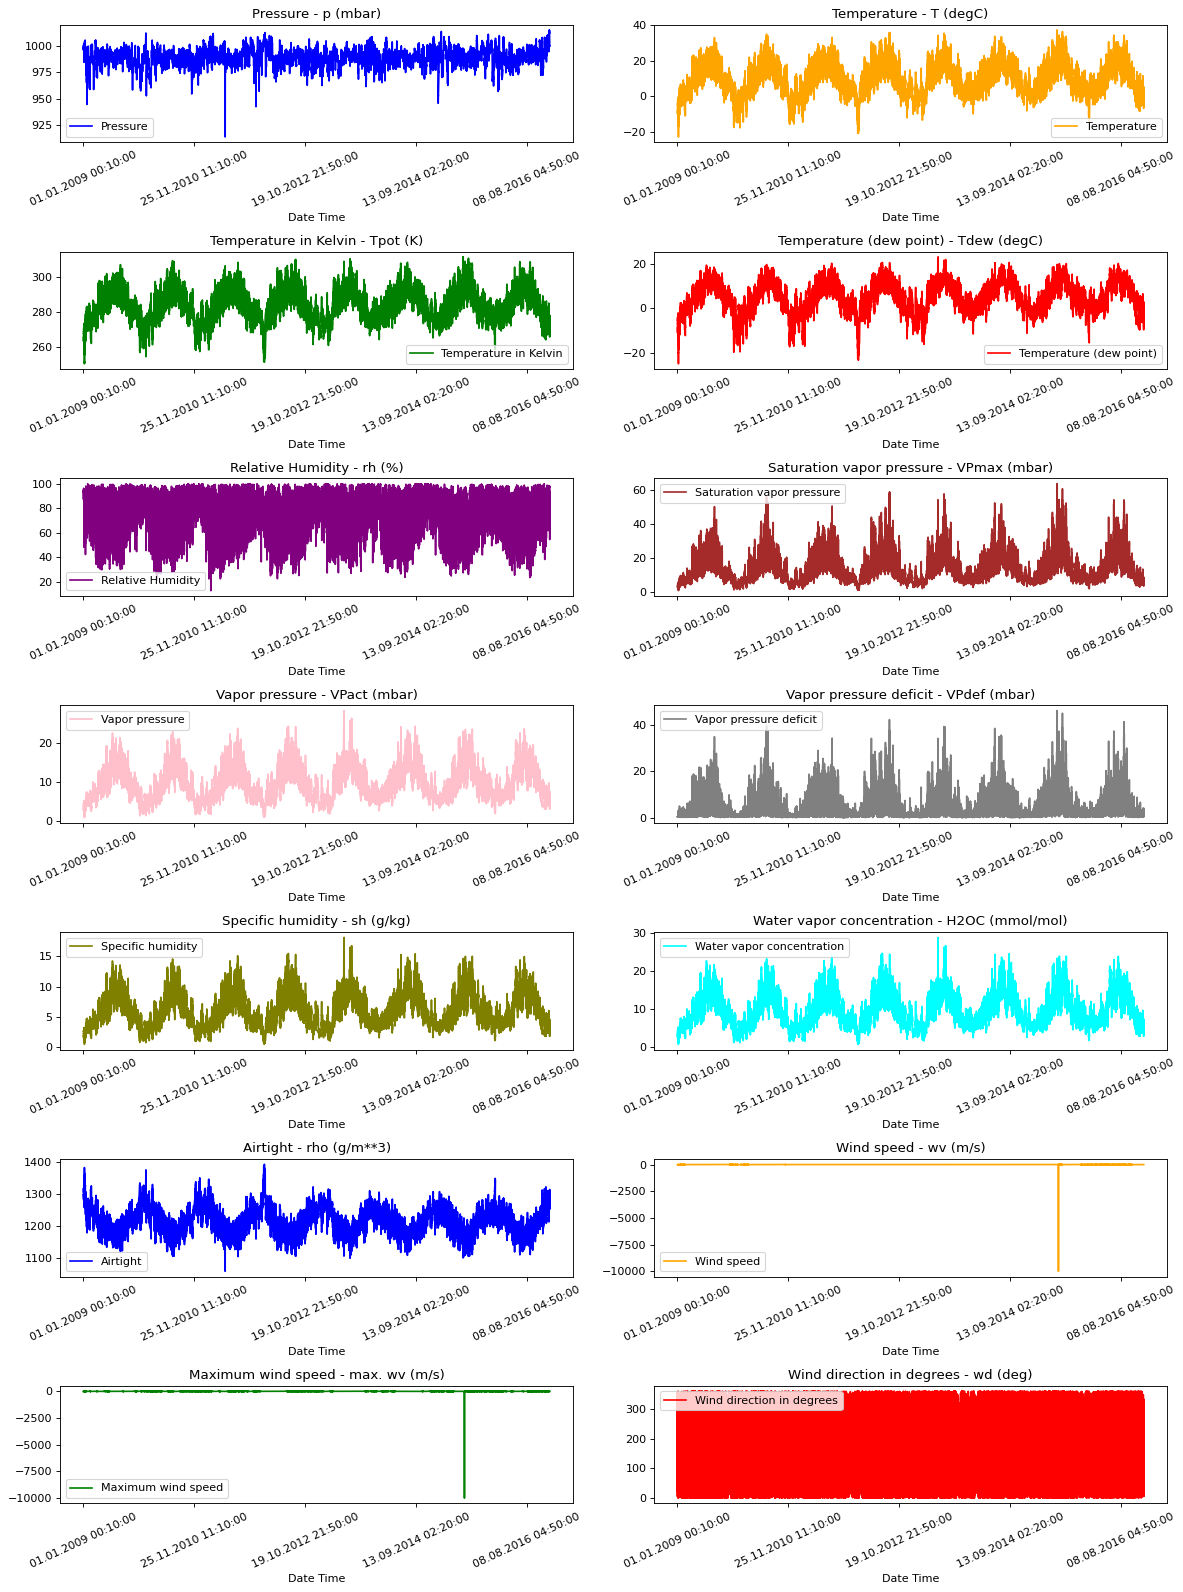

In [3]:
# visualise the raw data 
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)


In [5]:
# see how data look like 
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [6]:
# set date time as the index 
df = df.set_index(['Date Time'])
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2


In [7]:
# show summary of the data 
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [8]:
# clean bad values 
df = df[df['wv (m/s)'] != -9999.0]
df = df[df['max. wv (m/s)'] != -9999.0]
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2


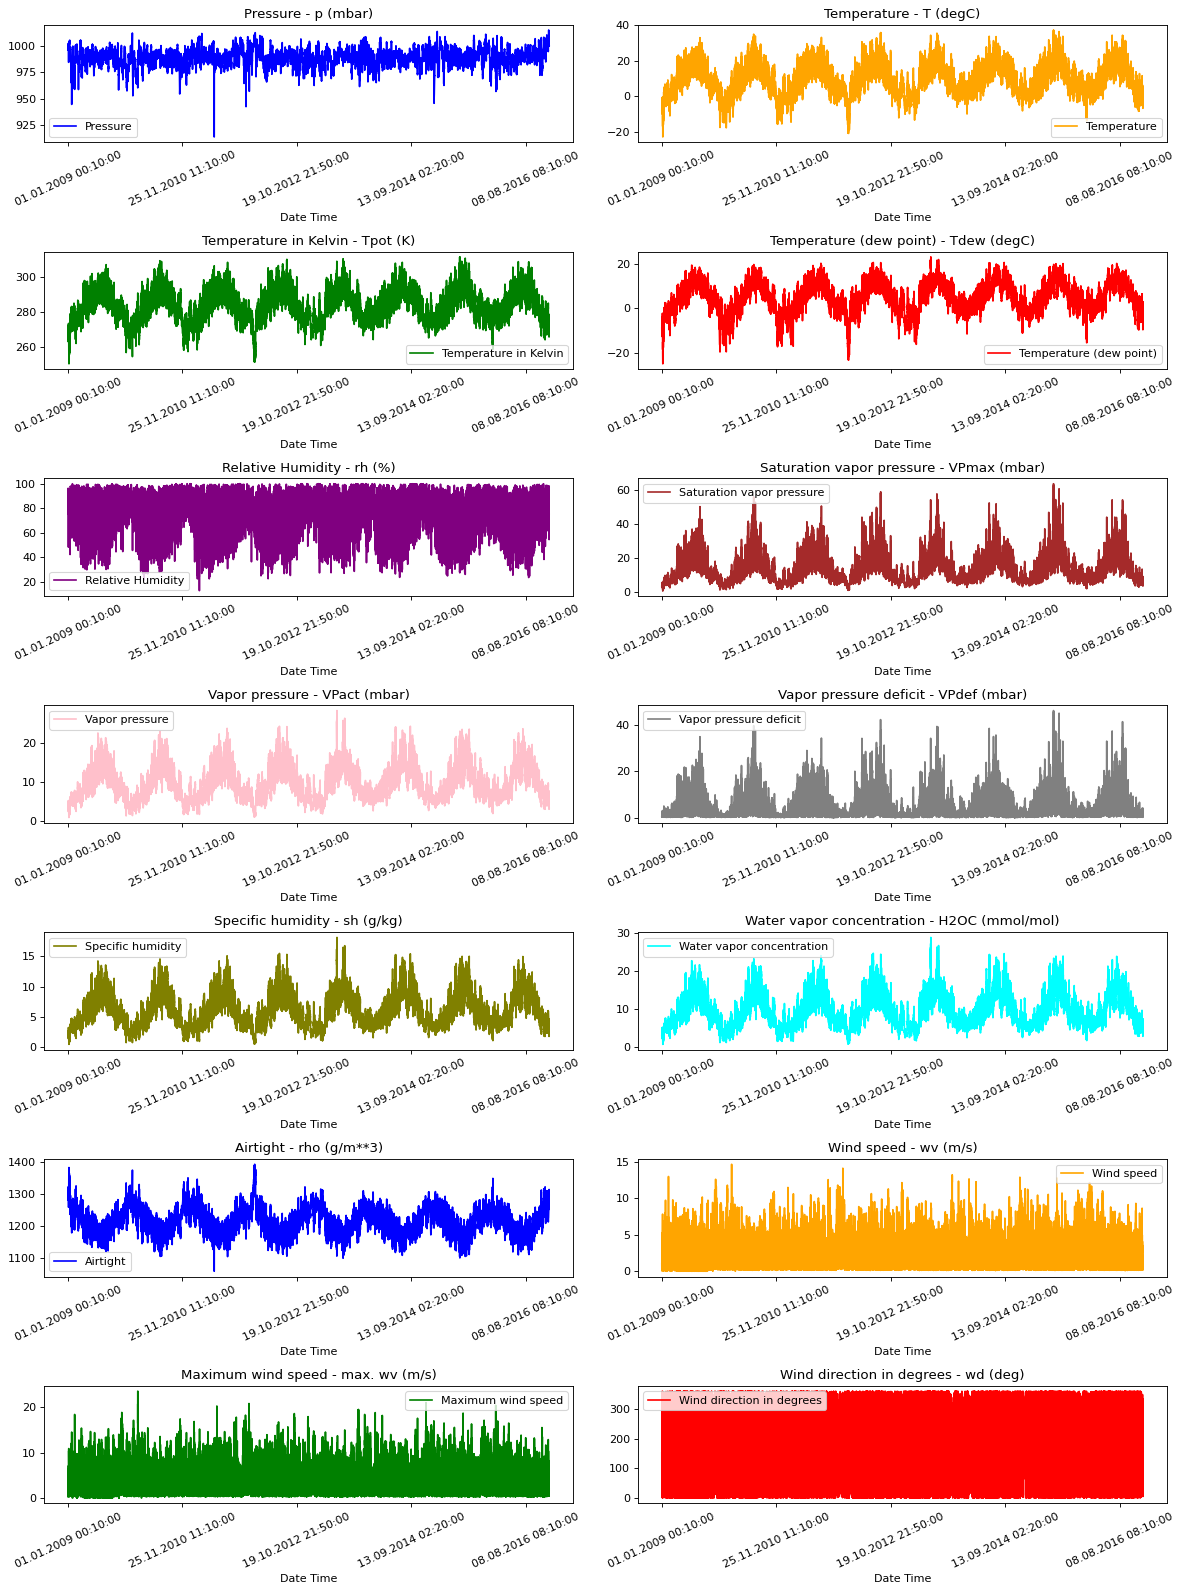

In [9]:
# visualise the data after cleaning
df = df.reset_index() # reset the index to use the visualisation function 
show_raw_visualization(df)

## Problem formulation: autoregressive forecasting 
## **Task**: predict the temperature of the next 12 hours, given the temperature of the past 5 days. 

### Obtain only temperature data 

In [10]:
df_temp = df['T (degC)']
df_temp 

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
                       ... 
31.12.2016 23:20:00   -4.05
31.12.2016 23:30:00   -3.35
31.12.2016 23:40:00   -3.16
31.12.2016 23:50:00   -4.23
01.01.2017 00:00:00   -4.82
Name: T (degC), Length: 420531, dtype: float64

### Format the "Date Time" so that it is understood by Pandas. Then we make it as the index for easy handling. 
### Resample data to 1-hour cadence using hourly mean to work with a smaller dataset 

In [11]:
df_temp = df_temp.reset_index()
# Format the string in the "Date Time" column as pandas datetime (a standard datetime object)
df_temp['Date Time'] = pd.to_datetime(df_temp['Date Time'], dayfirst=True)
# Make it as index 
df_temp = df_temp.set_index(['Date Time'])
# Resample the time cadence to 1 hour using mean
df_temp = df_temp.resample('1h').mean().interpolate()
df_temp

,T (degC)
Date Time,
2009-01-01 00:00:00,-8.304000
2009-01-01 01:00:00,-8.065000
2009-01-01 02:00:00,-8.763333
2009-01-01 03:00:00,-8.896667
2009-01-01 04:00:00,-9.348333
...,...
2016-12-31 20:00:00,-2.503333
2016-12-31 21:00:00,-2.653333
2016-12-31 22:00:00,-3.553333


<Axes: xlabel='Date Time'>

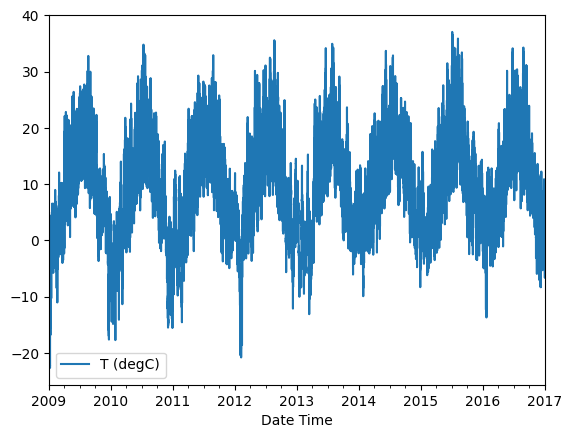

In [12]:
# Quickly visualise the temperature
df_temp.plot()

## Limit to the first 4 years to work with a small dataset 


In [13]:
df_temp = df_temp[datetime(2009,1,1):datetime(2013,1,1)]
df_temp 

,T (degC)
Date Time,
2009-01-01 00:00:00,-8.304000
2009-01-01 01:00:00,-8.065000
2009-01-01 02:00:00,-8.763333
2009-01-01 03:00:00,-8.896667
2009-01-01 04:00:00,-9.348333
...,...
2012-12-31 20:00:00,7.201667
2012-12-31 21:00:00,7.138333
2012-12-31 22:00:00,7.135000


### Define a sequence of temperature in numpy format 

In [14]:
temp_seq = df_temp.to_numpy()
print(temp_seq)
print(temp_seq.shape)

[[-8.304     ]
 [-8.065     ]
 [-8.76333333]
 ...
 [ 7.135     ]
 [ 6.30166667]
 [ 5.62      ]]
(35065, 1)


### Split the data to train:validation:test with ratio 8:1:1

In [15]:
### Split data with ratio 8:1:1 
train_ind_end = int(0.8 * temp_seq.shape[0])
val_ind_end = int(0.9 * temp_seq.shape[0])

train = temp_seq[:train_ind_end]
val = temp_seq[train_ind_end:val_ind_end]
test = temp_seq[val_ind_end:]

print(train, train.shape)
print(val, val.shape)
print(test, test.shape)

[[-8.304     ]
 [-8.065     ]
 [-8.76333333]
 ...
 [ 6.01833333]
 [ 5.84      ]
 [ 5.67      ]] (28052, 1)
[[ 5.55166667]
 [ 5.42833333]
 [ 5.29833333]
 ...
 [18.68333333]
 [17.46833333]
 [16.49166667]] (3506, 1)
[[15.44      ]
 [15.30333333]
 [15.35666667]
 ...
 [ 7.135     ]
 [ 6.30166667]
 [ 5.62      ]] (3507, 1)


### Scale the training data and obtain the scaling 

In [16]:
from sklearn.preprocessing import MinMaxScaler

## Scale the data frame
scaler = MinMaxScaler()

## Obtain scaler based on the "train" data
train_scaled = scaler.fit_transform(train)
train_scaled

array([[0.2498433 ],
       [0.25400464],
       [0.24184562],
       ...,
       [0.49921648],
       [0.49611143],
       [0.49315148]])

### Apply the scaling to validation and test data 

In [17]:
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

## Function to split data for autoregressive forecasting 

In [18]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

## Divide data to X (input: history) and y (target: forecast)
### Input length: 5 days = 5 (days) * 24 (points / day) = 120 data points 
### Output length: 12 hours = 12 points


In [19]:
# choose a number of time steps
# n_steps_in is the length of past data to be used in forecast 
# n_steps_out is the desired length of the output (prediction)
n_steps_in, n_steps_out = 120, 12

# split into samples : training set 
X_tra, y_tra = split_sequence(train_scaled, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_tra = X_tra.reshape((X_tra.shape[0], X_tra.shape[1], n_features))
y_tra = y_tra.reshape((y_tra.shape[0], y_tra.shape[1], n_features))

# split into samples : validation set 
X_val, y_val = split_sequence(val_scaled, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_val = X_val.reshape((X_val.shape[0], X_tra.shape[1], n_features))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], n_features))

## Create an LSTM model 

In [20]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

from keras import optimizers
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
import os

In [21]:
# define model
def create_model():
    model = Sequential()
    # define encoder 
    model.add(LSTM(32, activation='relu', input_shape=(n_steps_in, n_features))) 
    model.add(RepeatVector(n_steps_out)) # repeat encoding (to connect with the next layer)
    # define decoder 
    model.add(LSTM(32, activation='relu', return_sequences=True)) 
    # define output model by using a fully connected layer 
    # TimeDistributed wrapper allows us to apply the dense layer to each of the output time steps 
    model.add(TimeDistributed(Dense(16, activation='relu'))) #
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

## Run the model
### Save the best weights, stop training if no improvement after 5 consecutive epochs

In [22]:
%%time 

# create log folder if not exist 

model_path = 'Univariate-autoregressive-temperature/'

log_dir = "logs/fit/{}".format(model_path) + datetime.now().strftime("%Y%m%d-%H%M%S")

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# log the training as it goes 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# save best model 
filepath="Saved_models/{}".format(model_path)

if not os.path.exists(filepath):
    os.makedirs(filepath)

# create model checkpoint 
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath + "model_weights.best.hdf5", monitor='val_loss', verbose=1, save_best_only=True)

# stop if no improvement for 5 consecutive times 
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Call the model 
model=create_model()
model.summary()
    
### Fit the model
model.fit(X_tra, y_tra, epochs=50, 
        batch_size=256,
        validation_data=(X_val, y_val), 
        callbacks=[tensorboard_callback, earlystopping_callback, checkpoint])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 repeat_vector (RepeatVector  (None, 12, 32)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 12, 32)            8320      
                                                                 
 time_distributed (TimeDistr  (None, 12, 16)           528       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 12, 1)            17        
 tributed)                                                       
                                                        

Epoch 27/50
110/110 [==============================] - ETA: 0s - loss: 0.0017
Epoch 27: val_loss did not improve from 0.00176
110/110 [==============================] - 5s 48ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 28/50
110/110 [==============================] - ETA: 0s - loss: 0.0017
Epoch 28: val_loss improved from 0.00176 to 0.00171, saving model to Saved_models/Univariate-autoregressive-temperature/model_weights.best.hdf5
110/110 [==============================] - 5s 49ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 29/50
110/110 [==============================] - ETA: 0s - loss: 0.0016
Epoch 29: val_loss did not improve from 0.00171
110/110 [==============================] - 5s 48ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 30/50
109/110 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 30: val_loss did not improve from 0.00171
110/110 [==============================] - 6s 52ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 31/50
109/110 [===================

## Demonstrate prediction by taking the input sample, and compute the predicted temperature from the model 

In [23]:
# take an example of the input from 'test_scaled', from the beginning to the end of 5 days (used for prediction)
x_input = test_scaled[:n_steps_in]
# format the data to be able to use the model 
x_input = x_input.reshape((1, n_steps_in, n_features))
# let yhat be the prediction 
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[0.67226624]
  [0.65352017]
  [0.62944484]
  [0.6140251 ]
  [0.59701526]
  [0.5830164 ]
  [0.5745977 ]
  [0.57507056]
  [0.5864092 ]
  [0.60324305]
  [0.6214087 ]
  [0.6385304 ]]]


In [24]:
# format yhat structure to be able to use the rescaling function 
yhat = yhat.reshape(n_steps_out, n_features)
print(yhat)
print(yhat.shape)

[[0.67226624]
 [0.65352017]
 [0.62944484]
 [0.6140251 ]
 [0.59701526]
 [0.5830164 ]
 [0.5745977 ]
 [0.57507056]
 [0.5864092 ]
 [0.60324305]
 [0.6214087 ]
 [0.6385304 ]]
(12, 1)


### Unscale the data 

In [25]:
# Perform inverse scaling
predict = scaler.inverse_transform(yhat)
predict

array([[15.957159],
       [14.880508],
       [13.497782],
       [12.612176],
       [11.635242],
       [10.831242],
       [10.347729],
       [10.374886],
       [11.026102],
       [11.992926],
       [13.03624 ],
       [14.019594]], dtype=float32)

### Visualisation

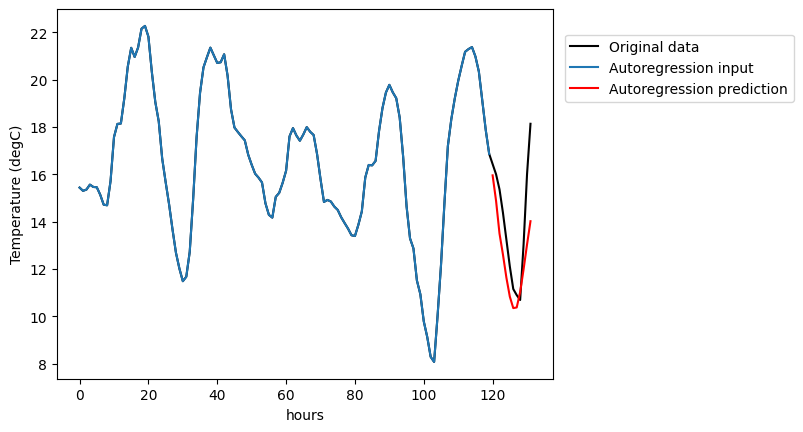

In [26]:
plt.plot(test[:n_steps_in+n_steps_out], color='k', label=r'Original data')
plt.plot(np.arange(0,n_steps_in), np.array(test[:n_steps_in]).reshape(n_steps_in), label='Autoregression input')
plt.plot(np.arange(n_steps_in,n_steps_in+n_steps_out), np.array(predict).reshape(n_steps_out), color='r', label='Autoregression prediction')
plt.xlabel('hours')
plt.ylabel('Temperature (degC)')
plt.legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
plt.show()

# Tasks: 
## - Evaluate the model performance
## - Improve the model performance, e.g., increasing training data, add model complexity  
